<a href="https://colab.research.google.com/github/adamd1985/Lectures_On_MLAI/blob/main/5_2_DBScan_Lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](img/330-banner.png)

# Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

This notebook we will try out the algorithms from the DBSCAN lesson.Intuitively, DBSCAN is based on the idea that clusters form dense regions in the data and so it works by identifying "crowded" regions in the feature space, and unlike K-Means it is very flexible.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

# Addressing K-Means failures

K-Means performs poorly if the clusters have more complex shapes (e.g., two moons data below).

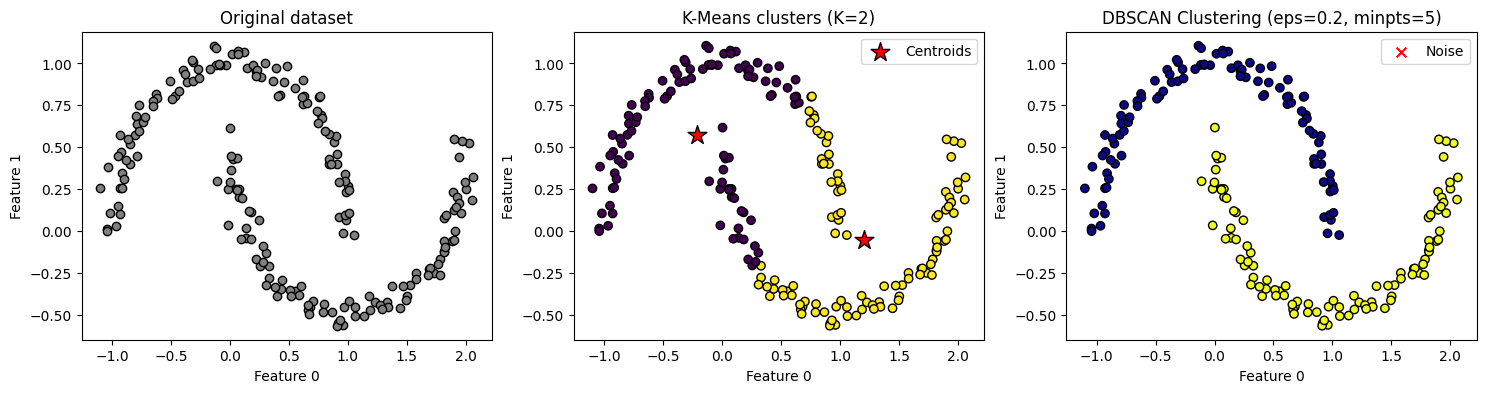

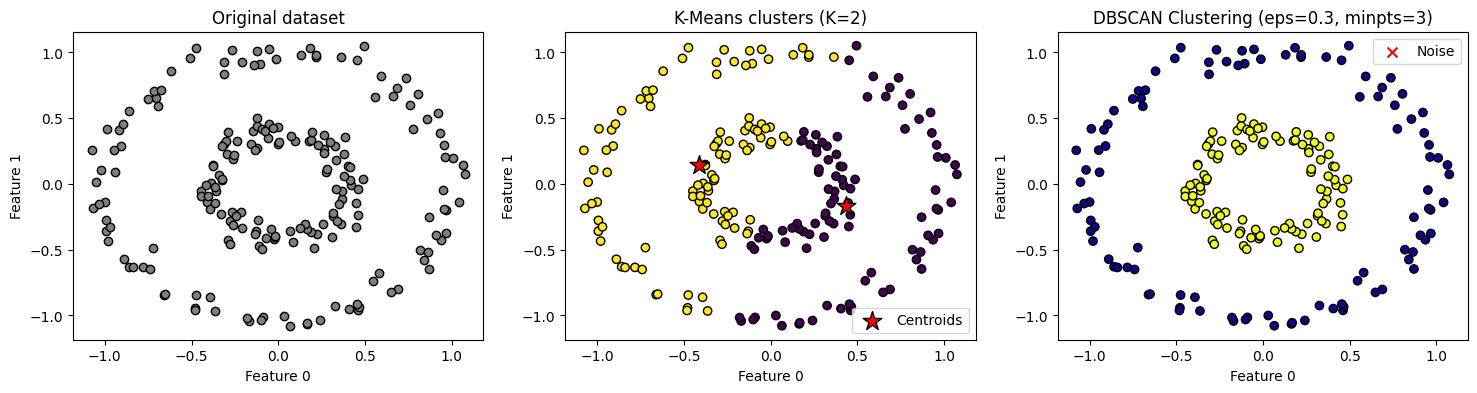

In [2]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_moons, make_circles, make_blobs

def plot_clustering(X, k=2, eps=0.2, min_samples=5):
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))

    ax[0].set_title("Original dataset")
    ax[0].set_xlabel("Feature 0")
    ax[0].set_ylabel("Feature 1")
    ax[0].scatter(X[:, 0], X[:, 1], c='gray', edgecolor='k')

    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    ax[1].set_title(f"K-Means clusters (K={k})")
    ax[1].set_xlabel("Feature 0")
    ax[1].set_ylabel("Feature 1")
    ax[1].scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis', edgecolor='k')
    ax[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                   c='red', marker='*', s=200, edgecolor='k', label='Centroids')
    ax[1].legend()

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)
    ax[2].set_title(f"DBSCAN Clustering (eps={eps}, minpts={min_samples})")
    ax[2].set_xlabel("Feature 0")
    ax[2].set_ylabel("Feature 1")
    noise_mask = labels == -1
    clustered_mask = ~noise_mask

    ax[2].scatter(X[clustered_mask, 0], X[clustered_mask, 1], c=labels[clustered_mask], cmap='plasma', edgecolor='k')
    ax[2].scatter(X[noise_mask, 0], X[noise_mask, 1], c='red', marker='x', s=50, label='Noise')
    ax[2].legend()
    plt.show()

X, y = make_moons(n_samples=200, noise=0.05, random_state=42)
plot_clustering(X, k=2, eps=0.2, min_samples=5)

X = make_circles(n_samples=200, noise=0.06, factor=0.4)[0]
plot_clustering(X, k=2, eps=0.3, min_samples=3)


It assumes that all directions are equally important for each cluster and fails to identify non-spherical clusters.

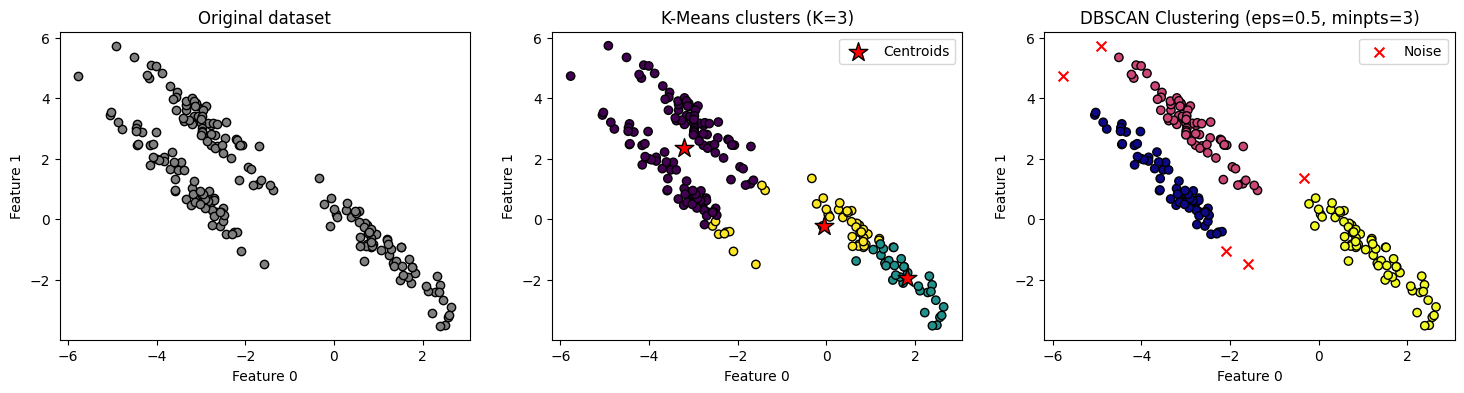

In [3]:
X, y = make_blobs(random_state=170, n_samples=200)
rng = np.random.RandomState(74)
transformation = rng.normal(size=(2, 2))
X = np.dot(X, transformation)
plot_clustering(X, k=3, eps=0.5, min_samples=3)

# The Algorithm

## Finding the ε-Neighbors

In DBSCAN, after computing the **ε-neighborhood**, the next step is to **identify all points** within a given radius $ \varepsilon $ of a particular point. This step is essential for:
- Determining whether a point is **a core point** (has at least MinPts neighbors).
- Expanding clusters based on density.
- Handling **border points** and **noise** effectively.


The **ε-neighborhood** of a point $ p $ is defined as:

$$
N_{\varepsilon}(p) = \{ q \in X \mid d(p, q) \leq \varepsilon \}
$$

where:
- $ d(p, q) $ is the **Euclidean distance** between points $ p $ and $ q $.
- $ \varepsilon $ is the **neighborhood radius**.

A point $ p $ is a **core point** if:

$
|N_{\varepsilon}(p)| \geq \text{MinPts}
$

This means that at least **MinPts** points (including $ p $ itself) must be within $ \varepsilon $ to form a dense cluster.


In [4]:
from sklearn.metrics.pairwise import euclidean_distances

def find_eps_neighbors(X, point_index, eps):
    distances = euclidean_distances([X[point_index]], X)[0]
    neighbors = np.where(distances <= eps)[0].tolist()
    neighbors.remove(point_index)
    return neighbors

X = np.array([
    [1, 2], [2, 3], [2, 2], [8, 8], [8, 9], [25, 80]
])

eps_neighbors = find_eps_neighbors(X, point_index=0, eps=2)
print("Epsilon neighborhood of point 0:", eps_neighbors)

Epsilon neighborhood of point 0: [1, 2]


## Classifying Core, Border, and Noise Points

After finding the **ε-neighborhood** of each point, the next step in DBSCAN is to classify points into three categories:

1. **Core Points**: Points with at least **MinPts** neighbors in their ε-neighborhood.
2. **Border Points**: Points that are not core points but are within **ε** of a core point.
3. **Noise Points**: Points that are neither core points nor border points.

These classifications determine whether a point will **initiate a cluster**, **belong to an existing cluster**, or **be treated as noise**.

A point $ p $ is a **core point** if:

$$
|N_{\varepsilon}(p)| \geq \text{MinPts}
$$

where:
- $ N_{\varepsilon}(p) $ is the set of all points within distance $ \varepsilon $ of $ p $.
- **MinPts** is the minimum number of points required for a point to be considered a dense region.

Core points **expand clusters** and help form the cluster's structure.

A point $ q $ is a **border point** if:
- It is **within** the ε-neighborhood of at least **one core point**.
- It has **fewer than MinPts** neighbors.

$$
|N_{\varepsilon}(q)| < \text{MinPts}, \quad \text{but} \quad \exists p \text{ (core point) such that } q \in N_{\varepsilon}(p)
$$

Border points **do not initiate clusters** but are included in a cluster if they are reachable from a core point.

A point $ n $ is a **noise point** if:
- It is **not a core point**.
- It is **not within** the ε-neighborhood of any core point.


$$
\forall p \in X, \quad |N_{\varepsilon}(n)| < \text{MinPts} \quad \text{and} \quad \nexists p \text{ (core point) such that } n \in N_{\varepsilon}(p)
$$

Noise points are considered **outliers** and are not assigned to any cluster.

Once we classify points, we follow these steps:
1. **Core points** become the **starting points** of clusters.
2. **Border points** are **absorbed into an existing cluster** (if they are in the neighborhood of a core point).
3. **Noise points** are **ignored** in clustering but may be used in anomaly detection.

In [5]:
def classify_points(X, eps, min_pts):
    classifications = {}
    for i in range(len(X)):
        neighbors = find_eps_neighbors(X, i, eps)
        if len(neighbors) >= min_pts:
            classifications[i] = "core"
        else:
            classifications[i] = "noise"
    for i in range(len(X)):
        if classifications[i] == "noise":
            neighbors = find_eps_neighbors(X, i, eps)
            if any(classifications.get(n) == "core" for n in neighbors):
                classifications[i] = "border"

    return classifications

X = np.array([
    [1, 2], [2, 3], [2, 2], [8, 8], [8, 9], [25, 80]
])

eps = 2
min_pts = 3
point_classes = classify_points(X, eps, min_pts)
print("Point classifications:", point_classes)

Point classifications: {0: 'noise', 1: 'noise', 2: 'noise', 3: 'noise', 4: 'noise', 5: 'noise'}


## Expanding Cluster

Once we classify points as **core, border, or noise**, the next step in DBSCAN is **expanding clusters** from core points. This ensures that all **density-connected points** are grouped together to form meaningful clusters.


DBSCAN follows a **density-reachability** principle to grow clusters.

A point $ q $ is **directly density-reachable** from a core point $ p $ if:
- $ q $ is in the **ε-neighborhood** of $ p $.
- $ p $ is a **core point**.

$$
q \in N_{\varepsilon}(p) \quad \text{and} \quad |N_{\varepsilon}(p)| \geq \text{MinPts}
$$

A point $ p_m $ is **density-reachable** from $ p_1 $ if there exists a **chain of points** $ p_1, p_2, ..., p_m $ such that each point is **directly density-reachable** from the previous point.

$$
p_1 = q, \quad p_m = p, \quad \text{and each } p_{i+1} \text{ is directly density-reachable from } p_i
$$

Two points $ p $ and $ q $ are **density-connected** if there exists a **core point $ o $** such that **both $ p $ and $ q $ are density-reachable from $ o $**.

This allows clusters to grow outward **without assuming spherical shapes** (unlike K-Means).

Once we detect a **core point**, we follow these steps:

1. **Start a new cluster** with an unvisited core point.
2. **Find all points in its ε-neighborhood**.
3. **Mark them as part of the cluster**.
4. **For each new core point added, repeat the process** (expand further).
5. **Stop when no more points can be reached**.

This process ensures that **all density-connected points** belong to the same cluster.


In [6]:
def expand_cluster(X, classifications, point_index, cluster_id, clusters, eps, min_pts):
    cluster_queue = [point_index]
    clusters[point_index] = cluster_id
    while cluster_queue:
        current_point = cluster_queue.pop(0)
        neighbors = find_eps_neighbors(X, current_point, eps)

        for neighbor in neighbors:
            if neighbor not in clusters:
                if classifications[neighbor] == "core":
                    clusters[neighbor] = cluster_id
                    cluster_queue.append(neighbor)
                elif classifications[neighbor] == "border":
                    clusters[neighbor] = cluster_id
                # else noise.

def dbscan(X, eps, min_pts):
    classifications = classify_points(X, eps, min_pts)
    clusters = {}
    current_cluster_id = 0

    for i in range(len(X)):
        if i not in clusters and classifications[i] == "core":
            expand_cluster(X, classifications, i, current_cluster_id, clusters, eps, min_pts)
            current_cluster_id += 1

    # Assign -1 to noise points
    for i in range(len(X)):
        if i not in clusters:
            clusters[i] = -1

    return clusters

X = np.array([
    [1, 2], [2, 3], [2, 2], [8, 8], [8, 9], [25, 80]
])
eps = 2
min_pts = 2
final_clusters = dbscan(X, eps, min_pts)
print("Final Clusters:", final_clusters)

Final Clusters: {0: 0, 1: 0, 2: 0, 3: -1, 4: -1, 5: -1}


## Predicting New Points

Now that we have implemented the **DBSCAN clustering algorithm**, the next step is to **predict the cluster of new points**. Unlike K-Means, DBSCAN does not use predefined centroids, so we must determine the cluster of a new point differently.

When a new point is introduced, we follow these steps:
1. **Find its ε-neighbors**: Identify points in the dataset that are within the **ε-neighborhood** of the new point.
2. **Check if any neighbors belong to an existing cluster**:
   - If neighbors exist, assign the **most common cluster** among them.
   - If no neighbors exist, classify the point as **noise**.
3. **Return the assigned cluster or mark as noise**.

The **ε-neighborhood** of a new point $ p $ is defined as:

$$
N_{\varepsilon}(p) = \{ q \in X \ | \ d(p, q) \leq \varepsilon \}
$$

where:
- $ d(p, q) $ is the **Euclidean distance** between $ p $ and all points in $ X $.
- $ \varepsilon $ is the **neighborhood radius**.

If $ N_{\varepsilon}(p) $ contains points that belong to a **cluster**, the new point is assigned to the **most frequent cluster** among them:

$$
\text{Cluster}(p) = \arg\max_{c} \text{Count}(N_{\varepsilon}(p), c)
$$

where $ c $ represents cluster labels in the ε-neighborhood.

In [7]:
def predict(X, clusters, new_point, eps):
    distances = euclidean_distances([new_point], X)[0]
    neighbors = np.where(distances <= eps)[0]

    if len(neighbors) == 0:
        return "noise"

    neighbor_clusters = [clusters.get(n, "noise") for n in neighbors if n in clusters]
    if len(neighbor_clusters) == 0:
        return "noise"

    return max(set(neighbor_clusters), key=neighbor_clusters.count)

new_point = np.array([8, 8.5])
predicted_cluster = predict(X, final_clusters, new_point, eps)
print("Predicted Cluster for new point:", predicted_cluster)

Predicted Cluster for new point: -1


# Silhouette Score

The **silhouette score** is a metric used to evaluate the quality of clustering. Since DBSCAN does not use centroids like K-Means, we must compute the silhouette score manually using **pairwise distances**.

For each point $ i $, the silhouette score is computed as:

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

where:
- **$ a(i) $ (intra-cluster distance)**: The average distance from point $ i $ to all other points in its **own cluster**.
- **$ b(i) $ (nearest-cluster distance)**: The average distance from point $ i $ to points in the **closest other cluster**.

The overall silhouette score is the **mean silhouette score** across all points:

$$
S = \frac{1}{N} \sum_{i=1}^{N} s(i)
$$

where $ N $ is the number of clustered points.

1. **Find $ a(i) $ - Cohesion (intra-cluster distance)**  
   - For each point, compute the **average Euclidean distance** to all other points in the **same cluster**.

2. **Find $ b(i) $ - Separation (nearest-cluster distance)**  
   - Compute the **average Euclidean distance** from $ i $ to **all points in the nearest cluster**.

3. **Compute $ s(i) $ for each point**  
   - Apply the silhouette formula:  

     $$
     s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
     $$

4. **Compute the overall silhouette score**  
   - Take the **mean** of all $ s(i) $ values:

     $$
     S = \frac{1}{N} \sum_{i=1}^{N} s(i)
     $$

In [8]:
def silhouette_score(X, clusters):
    unique_clusters = set(clusters.values()) - {"noise"}
    if len(unique_clusters) <= 1:
        return 0

    scores = []
    for i in range(len(X)):
        if i not in clusters or clusters[i] == "noise":
            continue

        same_cluster = [idx for idx in clusters if clusters[idx] == clusters[i] and idx != i]
        a_i = np.mean([np.linalg.norm(X[i] - X[j]) for j in same_cluster]) if same_cluster else 0
        other_clusters = [c for c in unique_clusters if c != clusters[i]]
        b_i = min(
            [
                np.mean([np.linalg.norm(X[i] - X[j]) for j in clusters if clusters.get(j) == c])
                for c in other_clusters
            ]
        ) if other_clusters else 0

        s_i = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) > 0 else 0
        scores.append(s_i)

    return np.mean(scores)

final_clusters = dbscan(X, eps, min_pts)
print("Final Clusters:", final_clusters)
ss = silhouette_score(X, final_clusters)
print("Silhouette Score:", ss)

Final Clusters: {0: 0, 1: 0, 2: 0, 3: -1, 4: -1, 5: -1}
Silhouette Score: 0.24426238131280933


Test it on Iris.

In [9]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris.data
scaler = StandardScaler()
X = scaler.fit_transform(X)

eps = 0.8
min_pts = 8
final_clusters = dbscan(X, eps, min_pts)
ss = silhouette_score(X, final_clusters)

print("Final Clusters:", np.array(list(final_clusters.values())))
print("Silhouette Score:", ss)

Final Clusters: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1
 -1 -1 -1 -1 -1 -1]
Silhouette Score: 0.5108084808380122


Test it against scikit learn [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

In [10]:
from sklearn.cluster import DBSCAN as SklearnDBSCAN
from sklearn.metrics import silhouette_score as sklearn_silhouette_score

sklearn_dbscan = SklearnDBSCAN(eps=eps, min_samples=min_pts)
sklearn_labels = sklearn_dbscan.fit_predict(X)
sklearn_silhouette = sklearn_silhouette_score(X, sklearn_labels) if len(set(sklearn_labels)) > 1 else 0

print("Scikit-learn DBSCAN Labels:", sklearn_labels)
print("Scikit-learn Silhouette Score:", sklearn_silhouette)

Scikit-learn DBSCAN Labels: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1 -1 -1  1
  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1]
Scikit-learn Silhouette Score: 0.5108084808380122


In [11]:
import hdbscan

hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5)
hdbscan_labels = hdbscan_clusterer.fit_predict(X)

hdbscan_silhouette = sklearn_silhouette_score(X, hdbscan_labels) if len(set(hdbscan_labels)) > 1 else 0

print("HDBSCAN Cluster Labels:", hdbscan_labels)
print("HDBSCAN Silhouette Score:", hdbscan_silhouette)

HDBSCAN Cluster Labels: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1]
HDBSCAN Silhouette Score: 0.49486290250095627


# Conclusion

DBSCAN is a powerful clustering algorithm that is particularly useful for detecting clusters of arbitrary shapes and identifying outliers. Unlike k-means, it does not require specifying the number of clusters in advance, making it a flexible choice for many applications.

One of the key strengths of DBSCAN is its ability to classify noise points, which helps in identifying anomalies in datasets. Additionally, it works well when clusters are well-separated and have similar densities.

However, DBSCAN has some limitations:
- It struggles when clusters have varying densities, as it may either split dense clusters into multiple smaller ones or merge distinct clusters into a single group.
- It does not support predicting the cluster assignment for new points, making it less useful for online learning.
- Choosing appropriate values for the hyperparameters, `eps` and `min_pts`, is crucial for good performance. These parameters are not always intuitive, and small changes can significantly affect the results.

For datasets with clusters of varying densities, an improved version called **HDBSCAN** provides a more robust solution by automatically adjusting density-based clustering decisions.

What We Learned:
- DBSCAN can identify arbitrarily shaped clusters and detect outliers.
- The concept of core, border, and noise points in clustering.
- The algorithm.
- The limitations of DBSCAN, including its struggles with clusters of varying densities.
- How DBSCAN compares with k-means and hierarchical clustering.
